# Install tensorflow

In [88]:
import numpy as np
import random
import tensorflow as tf
import os
import csv
# import keras

#Replay

In [89]:
class MemoryBase(object):
    # Define Abstract Class for MemmoryBase
    def __init__(self, capability=2000):
        """
        Initialize method for creating a new instance of memory based
        + Params: capability: Integer
        """
        self.capability = capability
        self.queue = {
                        "s":[],
                        "a":[],
                        "ns":[],
                        "r":[],
                        "d":[]
                    }
        self.cur_size = 0
        self.pris = None

    def insert_samples(self, samples):
        """
        Perform Inserting New Observations into Memory
        + Params: samples
        """
        pass

    def sel_samples(self, batch_size):
        """
        Perform Selecting Observations from Previous
        """
        pass

    def clrqueue(self):
        """
        Perform Clearing Observations in this Queue
        """
        pass

class Memory(MemoryBase):
    """
    Declare Memory for Training Deep Reinforcement Learning
    """
    def __init__(self, capability):
        super(Memory, self).__init__(capability)

    
    def insert_samples(self, samples):
        """
        Insert Samples to Queue
        + Params: samples: Dictionary
        + Returns: None 
        """
        if self.queue.keys() != samples.keys():
            raise Exception("Inserted Samples are't the same format")
        num_sams = len(samples["s"])
        for key in self.queue.keys():
            self.queue[key] = samples[key] + self.queue[key]
        if self.cur_size + num_sams <= self.capability:
            self.cur_size += num_sams
            return 
        # Remove Over Samples in a Queue
        for key in self.queue.keys():
            self.queue[key] = self.queue[key][0:self.capability]
        self.cur_size = self.capability
        return

    def sel_samples(self, batch_size):
        """
        Select n samples from queue
        + Params: batch_size: Integer
        """
        batch = {"s":[], "a":[], "ns":[], "r":[], "d":[]}
        
        if batch.keys() != self.queue.keys():
            raise Exception("Format of Batch and Queue must be same")
        if self.cur_size <= batch_size:
            return self.queue 
        idxs = random.sample(list(range(self.cur_size)), batch_size)
        for idx in idxs:
            for key in self.queue.keys():
                batch[key].append(self.queue[key][idx])
        return batch

    def clrqueue(self):
        """
        Perform Clearing Observations
        """
        self.cur_size = 0
        for key in self.queue.keys():
            self.queue[key] = []

#DQL

In [90]:
# Backbone Architecture
class Backbone:
	def __init__(self, out_dims):
		
		self.layers = [
			tf.keras.layers.Dense(units=32, activation=tf.nn.relu),
			tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
			tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
			tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
			# tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
			tf.keras.layers.Dense(units=out_dims)
		]
	
	def __call__(self, inputs):
		# Call Function
		x = inputs
		outputs = self.call(inputs)
		return outputs
	
	def call(self, inputs):
		# Perform
		x = inputs
		for layer in self.layers:
			x = layer(x)
		return x

class DQL:
	def __init__(self, input_dims, num_actions, backbone,fname='dqn_model.h5'):
		"""
		Initial Method for Deep Q Learning Method
		params: input_dims: Integer
		params: num_actions: Integer
		returns: None
		"""
		self.input_dims = input_dims
		self.num_actions = num_actions
		self.backbone = backbone
		self.model_file = fname
		self.states = tf.compat.v1.placeholder(dtype=tf.float32,
							shape=(None, self.input_dims))
		self.next_states = tf.compat.v1.placeholder(dtype=tf.float32,
								shape=(None, self.input_dims))
		self.actions = tf.compat.v1.placeholder(dtype=tf.int32, shape=(None,))
		self.rewards = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None,))
		self.dones = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None, ))
		self.gamma = tf.compat.v1.placeholder(dtype=tf.float32, shape=None)
		self.lr = tf.compat.v1.placeholder(dtype=tf.float32, shape=None)

		self._define_model()

	def _define_model(self):
		# Create the Deep Q Learning agent
		self.agent = self.backbone(out_dims=self.num_actions)
  		# self.agent = tf.keras.applications.resnet50.Resnet50(
		# 	  weights = 'imagenet',
		# 	  input_tensor = None,
		# 	  input_shape = None,
		# 	  pooling = None,
		# 	  classes = self.num_actions)
		self.q_values = self.agent(self.states)
		#print(f"q_values: {self.q_values}")
		q_action_values = tf.reduce_sum(self.q_values , axis=-1)
		# Using Bellman Equation to Caculate Ground-Truth
		q_next_values = self.agent(self.next_states)
		q_next_values = tf.reduce_max(q_next_values, axis=-1)
		label = (q_next_values * (1.0 - self.dones)) * self.gamma + self.rewards
		# define Objective Function
		self.loss = tf.losses.mean_squared_error(label, q_action_values)
		self.opt = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(loss=self.loss)
		self.regularizer = tf.keras.regularizers.L1L2(l1=0.0, l2=0.1)
	# def save_model(self):
	# 	self.q_values.save(self.model_file)
	# def load_model(self):
	# 	self.q_eval = tf.keras.models.load_model(self.model_file)
def sel_action(env, model, sess, state, epsilon):
	"""
	perform selecting action for Deep Q Learning Method

	"""
	A = np.random.random()
	if A <= epsilon:
		action = env.sam_action()
		return action
	else:
		state = np.expand_dims(state, axis=0)
		# Run Inference
		[q_values] = sess.run([model.q_values],
						feed_dict={model.states: state})
		#print(f"q values 1: {q_values}")
		q_values = q_values[0]
		act_idx = np.argmax(q_values)
		action = env.index2action(act_idx)
		return action

# if __name__ == "__main__":
# 	model = DQL(input_dims=8, num_actions=10, backbone=Backbone)

#Env

In [91]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import os

class Helper:
    def __init__(self, rc, max_f, max_c):
        """
        Initial Method for Continuous Environment
        params - rc: float - Radius Cycle
        params - max_f: float - Maximum CPUs
        params - max_c: float - Maximum Costs
        """
        if rc < 0 or max_f < 0 or max_c < 0:
            raise Exception(
                    "Initial Values for Helper must be Positive!"
                )
        self.rc = rc
        self.max_f = max_f
        self.max_c = max_c

        self.f = None
        self.c = None

    # def become_stranger(self):
    #     """This node become to a Stranger Node"""
    #     f_frac = np.random.uniform(low=1e-6, high=1e-5)
    #     c_frac = np.random.uniform(low=0.08, high=0.01)
    #     self.f = self.f * f_frac
    #     self.c = self.c * c_frac

    #     if np.random.rand() < 0.9:
    #         self.c = self.c  * f_frac * np.random.uniform(low=10.0, high=20.0)
    #     else:
    #         self.c = self.c * f_frac

    def reset(self):
        """
        Create a New Instance
        """
        self.f = np.random.normal(loc=self.max_f * 0.5, scale=self.max_f * 1e-4)
        self.c = np.random.normal(loc=self.max_c * 0.5, scale=self.max_c * 1e-4)

        # if np.random.rand() < 0.1:
        #     self.become_stranger()

        if self.f < 0:
            self.f = self.max_f * 0.5
        if self.c < 0:
            self.c = self.max_c * 0.5

    def transit(self):
        """
        Move to a Next State
        """
        self.f = np.random.normal(loc=self.f, scale=self.max_f * 1e-4)
        self.c = np.random.normal(loc=self.c, scale=self.max_c * 1e-4)

        if self.f < 0:
            self.f = self.max_f * 0.5

        if self.c < 0:
            self.c = self.max_c * 0.5

        # if np.random.rand() < 0.1:
        #     self.become_stranger()

    def cal_com_latency(self, num_bytes):
        """
        Calculate The Latency for Computing "num_bytes" data 
        params: num_bytes - Integer - Computation Demand
        """
        num_bytes = float(num_bytes)
        latency = num_bytes / self.f
        return latency

    def cal_offload_latency(self, num_bytes, mu, m, d_n):
        """
        Calculate The Latency for Offloading "num_bytes" data
        params: num_bytes - Integer - Offloading Demand
        """
        num_bytes = float(num_bytes)
        # Transformation Parameters
        CO = 3*1e8
        Fc = 1e4
        BW = 10e7
        G_RA = 1.8
        P_max = 500*10**(-3)
        Loss_free = (4*np.pi* Fc * d_n/CO)**2
        sigma_2 = 4*10**(-21)

        pr = (mu*P_max*(G_RA)**2)/Loss_free
        SNR = m*pr/(BW*sigma_2)
        rn = (BW/m) * np.log2(1.0 + SNR) 
        latency = num_bytes / rn
        return latency

    def cal_incentive_cost(self, num_bytes):
        """
        Calculate the Incentive Cost for Processing "num_bytes" data
        params: - num_bytes : Integer
        """
        cost = self.c * self.cal_com_latency(num_bytes)
        return cost

    def show_cur_state(self):
        print("d: {:.3f}, f: {:.3f}, c: {:.10f}".format(self.d, self.f, self.c))

    def get_state(self):
        """
        Get the Current State of This Helper
        """
        state = [self.f/self.max_f, self.c/self.max_c]

        return state

class TaskOffloadEnv:
    def __init__(self, n_helpers, rc, max_f, max_c, max_l, alpha1, alpha2, alpha3, alpha4, v_min, v_max,  seed):
        """
        Initial Method for Task Offload Environments
        """
        self.n_helpers = n_helpers

        self.rc = rc
        self.max_f = max_f
        self.max_c = max_c
        self.max_l = max_l

        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.alpha3 = alpha3
        self.alpha4 = alpha4
        self.helpers = {}
        self.step_counter = 0

        self.v_min = v_min
        self.v_max = v_max

        self.curr_n_helpers = self.n_helpers

        # environment's configuration
        self.act_dims = [self.n_helpers] + [2 for _ in range(self.n_helpers)] + [2] 
        self.num_actions = self.n_helpers * (2 ** self.n_helpers) * 2
        self.env_dims = 2 + self.n_helpers * 6

        # Client initialization
        self.x_0 = 0
        self.y_0 = 0
        self.v_x = 0
        self.v_y = 0

        self.userList_x = []
        self.userList_y = []
        self.userList_location = []
        
        self.userList_velocity_x = []
        self.userList_velocity_y = []
        self.userList_velocity = []

        self.d_n = 0

        np.random.seed(seed)

    def _clientInit(self, ):
      for user_no in range(self.n_helpers):
        user_Radius = random.uniform(self.rc/2, self.rc)
        line = [1,3]
        line = random.choice(line)
        if line == 1:
          user_Angle  = math.asin(self.rc/2/user_Radius)
        # elif line == 2:
        #   user_Angle  = math.asin(0/user_Radius)
        else:
          user_Angle  = math.asin(-self.rc/2/user_Radius)

        user_x1 = self.x_0 + user_Radius * math.cos(user_Angle)
        user_x2 = self.x_0 - user_Radius * math.cos(user_Angle)
        user_x = random.choice([user_x1, user_x2])
        user_y = self.y_0 + user_Radius * math.sin(user_Angle)

        # velocity
        user_vy= 0
        user_vx = random.uniform(self.v_min , self.v_max)
        self.userList_x.append(user_x)
        self.userList_y.append(user_y)
        self.userList_location.append([user_x, user_y])
        self.userList_velocity.append([user_vx, user_vy])

      # # Client Plot
      # fig, ax = plt.subplots()                                                
      # circle1 = plt.Circle((self.x_0, self.y_0), self.rc, color='b', fill=False) 
      # circle2 = plt.Circle((self.x_0, self.y_0), 1, color='r', fill=True)       
      # ax.add_patch(circle1)
      # ax.add_patch(circle2)
      # print(f"List of user location is: {self.userList_location}")
      # print(f"List of user velocity is: {self.userList_velocity}")
      # plt.scatter(self.userList_x, self.userList_y)
      # plt.show()
    
    def distance(self):
      userList_distance = []            
      # init client location:               
      client_location = (self.x_0, self.y_0)
      for user_no in range(self.n_helpers):
        #print(f"user_no {user_no}")
        user_distance = np.linalg.norm(np.array(self.userList_location[user_no]) - np.array(client_location))
        userList_distance.append(user_distance)
      #print(f"List of user distance is: {userList_distance}")
      return userList_distance

    def get_state(self):
        """
        Get Environment State
        """
        
        client_state = [self.l*1.0/self.max_l]
        helper_state = []
        userList_distance = self.distance()
        num_helpers = 0
        for key in sorted(list(self.helpers.keys())):                    
          if userList_distance[key] > self.rc:
            state_f_c = [0,0]
          else:
            helper = self.helpers[key]
            state_f_c = helper.get_state()
            num_helpers = num_helpers + 1
          location = self.userList_location[key]
          x = location[0]/self.rc
          y = location[1]/self.rc
          position = [x,y]
          velocity = self.userList_velocity[key]
          v_x = velocity[0]/self.v_max
          v_y = velocity[1]/self.v_max
          v= [v_x, v_y]
          state = position + v + state_f_c
          helper_state += state
          
        env_state = [num_helpers] + client_state + helper_state
        #print(f"env_state : {env_state}")
        return env_state

    def reset(self):
        """
        Create a New Instance
        """
        self._clientInit()
        self.l = np.random.normal(loc=self.max_l * 0.5, scale=self.max_l * 1e-6)
        if self.l < 0:
            self.l = self.max_l * 0.5
        self.step_counter = 0
        for idx in range(self.n_helpers):
            self.helpers[idx] = Helper(self.rc, self.max_f, self.max_c)
            self.helpers[idx].reset()            
        self.client_f = self.max_f * np.random.normal(loc=0.0001, scale= 1e-6)

        state = self.get_state()
        #print(f"List of user state is: {state}")
        return state

    def Markov_chain(self,num_n_vehicles):

      n_vehicle_state = {0 : "N1",1 : "N2",2 : "N3", 3 : "N4", 4 : "N5"}
      State_1 = [0.4, 0.5, 0.05, 0.05, 0]
      State_2 = [0.3, 0.2, 0.3, 0.1, 0.1]
      State_3 = [0, 0.3, 0.3, 0.4, 0]
      State_4 = [0.05, 0.05, 0.3, 0.3, 0.3]
      State_5 = [0, 0.1, 0.2, 0.3, 0.4]
      transitionMatrix = np.array([State_1, State_2, State_3, State_4, State_5])
      activityList = []
      start_n_vehicles = num_n_vehicles - 1 
      next_n_vehicles = np.random.choice([0,1,2,3,4], p = transitionMatrix[start_n_vehicles])
      return next_n_vehicles + 1

    def transmit(self, curr_n_vehicles):
      # x = x + v_x*t, y = y + v_y*t
      y_vecto = []
      over_n_vehicles = 0
      index = []
      for user_no in range(self.n_helpers):
        self.userList_location[user_no][0] = self.userList_location[user_no][0] + self.userList_velocity[user_no][0]
        self.userList_location[user_no][1] = self.userList_location[user_no][1] + self.userList_velocity[user_no][1]

      userList_distance = self.distance()
      for user_no in range(self.n_helpers):
        if userList_distance[user_no] > self.rc:
          over_n_vehicles += 1
          index.append(user_no)
      remain_n_vehicles = curr_n_vehicles - over_n_vehicles

      next_n_vehicles = self.Markov_chain(remain_n_vehicles)

      if next_n_vehicles > remain_n_vehicles:
        add_num = next_n_vehicles - remain_n_vehicles
        #print(f"add_num: {add_num}")
        for i in range(add_num):
            idx = index[i]
            self.userList_location[idx], self.userList_velocity[idx] = self.out_of_range(add_num) 
        curr_n_vehicles = next_n_vehicles

      else:
        curr_n_vehicles = remain_n_vehicles     
      #print(f"curr_n_vehicles is: {curr_n_vehicles}")
      for key in self.helpers.keys():
        self.helpers[key].transit()

      # fig, ax = plt.subplots()                                                
      # circle1 = plt.Circle((self.x_0, self.y_0), self.rc, color='b', fill=False) 
      # circle2 = plt.Circle((self.x_0, self.y_0), 1, color='r', fill=True)       
      # ax.add_patch(circle1)
      # ax.add_patch(circle2)
      # userList_x,userList_y = [],[]
      # for user_no in range(self.n_helpers):
      #   x = self.userList_location[user_no][0]
      #   y= self.userList_location[user_no][1]
      #   userList_x.append(x)
      #   userList_y.append(y)
      # plt.scatter(userList_x, userList_y)
      # plt.show()
    
    def out_of_range(self, num):
      # When vehicles go through the circle
        user_Radius = random.uniform(self.rc/2, self.rc)
        line = [1,3]
        line = random.choice(line)
        if line == 1:
          user_Angle  = math.asin(self.rc/2/user_Radius)
        # elif line == 2:
        #   user_Angle  = math.asin(0/user_Radius)
        else:
          user_Angle  = math.asin(-self.rc/2/user_Radius)

        user_x = self.x_0 - user_Radius * math.cos(user_Angle)
        user_y = self.y_0 + user_Radius * math.sin(user_Angle)

        # velocity
        user_vy= 0
        user_vx = random.uniform(self.v_min , self.v_max)
        location = [user_x, user_y]
        velocity = [user_vx, user_vy]
        return location, velocity


    def step(self, action):
        """
        Perform an action
        action's format [k, a1, ..., aN, B_c]

        """
        done = False
        c0 = 3*10**8
        P_max = 200*10**(-3)
        G_RA = 1.8
        sigma_c = 100
        P_ra_min = 10**(-13)
        Lambda = 0.1
        f_rad = 76*10**9

        k = action[0]
        if action[-1] == 1:
          Power = 0.7
        else:
          Power = 0.9
        mu = Power
        a_vec = action[-self.n_helpers-1:-1]
        m = sum(a_vec)
        standard_time = self.l / self.client_f      
        com_fee, total_latency, required_connect = [], [], []
        num_bytes = self.l / k
        userList_distance = self.distance()
        for idx in sorted(list(self.helpers.keys())):
            if a_vec[idx] == 0:
                total_latency.append(np.Inf)
                com_fee.append(0.0)
                required_connect.append(0.0)
            else:
                helper = self.helpers[idx]
                d_n = userList_distance[idx]
                offload_latency = helper.cal_offload_latency(num_bytes, mu, m, d_n)
                com_latency = helper.cal_com_latency(num_bytes)
                fee = helper.cal_incentive_cost(num_bytes)
                com_fee.append(fee)
                total_n = offload_latency + com_latency
                total_latency.append(total_n)
                duration = self.constrain(self.rc, self.userList_velocity[idx][0], 0 , d_n, 0)
                if total_n <= duration:
                  rw_link =  Lambda
                else:
                  rw_link = 0
                required_connect.append(rw_link)

        total_latency = sorted(total_latency)
        required_latency = max(total_latency[:k])
        required_fee = np.sum(com_fee)
        connect_rw = np.sum(required_connect)
        lamda_rad = c0/f_rad
        res_max = (P_max*(G_RA)**2*lamda_rad**2*sigma_c/(4*(np.pi)**2*P_ra_min))**(1/4)
        res = ((1-mu)*P_max*(G_RA)**2*lamda_rad**2*sigma_c/(4*(np.pi)**2*P_ra_min))**(1/4)
        rw_anten =  res/res_max
        required_anten =  rw_anten
        done = False
        # Calculate in Case the action meets the conditions
        if k <= m:
            if required_latency > standard_time:
                com_reward = -standard_time
            else:
                com_reward = standard_time - required_latency
            com_reward = com_reward * self.alpha1
            cost_reward = required_fee * self.alpha2
            anten_reward =  required_anten*self.alpha3
            connect_reward = connect_rw*self.alpha4
            total_reward = com_reward - cost_reward + anten_reward + connect_reward
        else:
            """
            an action doesn't meet the conditions
            """
            com_reward = -1.0 * self.alpha1 * standard_time
            cost_reward = 1.0 * self.alpha2 * required_fee
            if m == 0:
                cost_reward = (self.l / self.client_f) * self.max_c
            anten_reward =  required_anten*self.alpha3
            connect_reward = connect_rw*self.alpha4
            total_reward = com_reward - cost_reward + anten_reward + connect_reward
        reward = [total_reward, com_reward, cost_reward, anten_reward, connect_reward]
        
        """
        Move to the next State
        """
        self.l = np.random.normal(loc=self.l, scale=self.max_l * 1e-6)
        if self.l < 0:
            self.l = self.max_l * 0.5

        self. transmit(self.curr_n_helpers)
        next_state = self.get_state()
        return next_state, reward, done

    def sam_action(self):
        """
        select one action randomly
        action's format [k, a1, ..., aN]
        """
        k = random.randint(1, self.n_helpers)
        if k==1:
          x=1
        else:
          x=k//1.5
        n = random.randint(x, self.n_helpers)
        # mylist = [0.7, 0.9]
        # Power = []
        # for i in range(len(mylist)):
        #   if mylist[i]==0.7:
        #     pw = 1
        #   else:
        #     pw = 2
        #   Power.append(pw)

        # mu = random.choice(Power)
        mu=random.choice([1, 2])
        a_vec = [0.0 for _ in range(self.n_helpers)]
        sel_helper_idxs = np.random.permutation(self.n_helpers)[0:n]
        for helper_idx in list(sel_helper_idxs):
            a_vec[helper_idx] = 1.0
        action = [k] + a_vec + [mu]
        return action

    def constrain(self, D, v_n, v_t, z_n, z_t):
      duration = D/(v_n-v_t) - (z_n - z_t)/(v_n-v_t)
      return duration

    def action2index(self, action):
        """
        Convert action from nulti-dimension format to index format
        """
        if len(action) != len(self.act_dims):
            raise Exception("Shape Error")
        
        act_idx = action[0] - 1
        for i in range(1, len(self.act_dims)-1):
            act_idx = act_idx * self.act_dims[i] + action[i]
        act_idx = act_idx * 2 + (action[-1] - 1)
        return act_idx

    def index2action(self, act_idx):
        """
        Convert action from index format to multi-dimension format
        """
        action = []
        action_bw = act_idx % 2
        act_idx = (act_idx - action_bw)/2
        #action_bw = action_bw + 1
        for i in range(len(self.act_dims)-1, 1, -1):
            ai = act_idx % self.act_dims[i-1]
            action.append(int(ai))
            act_idx = (act_idx - ai) / self.act_dims[i-1]
        
        action.append(int(act_idx))
        action = [action_bw+ 1] + action
        action.reverse()
        action[0] = action[0] + 1
        return action

if __name__ == "__main__":
    env = TaskOffloadEnv(n_helpers=5,rc=100,max_f=100,max_c=100,max_l=100,alpha1=1.0,alpha2=1.0,alpha3=1.0,alpha4=1.0, v_min=0,v_max=50,seed=1)
    action = env.sam_action()
    idx = env.action2index(action)
    recovered = env.index2action(idx)
    print(idx)
    print(action, recovered)


91.0
[2, 0.0, 1.0, 1.0, 0.0, 1.0, 2] [2, 0, 1, 1, 0, 1, 2.0]


# Parameters

In [92]:
n_helpers = 5
rc = 100.0
max_f = 2e9
max_c = 1e3
max_l = 3e5*8
alpha1 = 4.6
alpha2 = 1.8
alpha3 = 5.0
alpha4 = 5.0
BW = 10e7
seed = 1
v_min = 0
v_max = 10
num_episodes = 70
max_step_per_episode = 500
buffer_size = 2000
batch_size = 32
max_eps = 1.0
epsilon = max_eps
min_eps = 0.1
gpu_idx = -1
log_dir = "../log"

CHECKPOINT = 20

#Main

In [93]:
gamma = 0.99
epsilon_decay = 0.9999
env = TaskOffloadEnv(n_helpers,rc,max_f,max_c,max_l,alpha1,alpha2,alpha3, alpha4, v_min, v_max, seed)
nS = env.env_dims
print(nS)
nA = env.num_actions
print(nA)
lr = 1e-3
discount_rate = gamma
model = DQL(input_dims=env.env_dims,num_actions=env.num_actions,backbone=Backbone)
model_target = DQL(input_dims=env.env_dims,num_actions=env.num_actions,backbone=Backbone)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
gpu_option = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
tf.debugging.set_log_device_placement(True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_option))
sess.run(tf.global_variables_initializer())
container = Memory(buffer_size)
log_total_reward, log_comp_reward, log_cost_reward, log_anten_reward, log_connect_reward = [], [], [], [], []
update_target_network = 1000

32
320


# Training

In [94]:
epsilon = max_eps
frame_count = 0
for episode in range(num_episodes):
	state = env.reset()
	for step in range(max_step_per_episode):
		epsilon *= 0.9999
		epsilon = max(epsilon,min_eps)
		frame_count +=1
		action = sel_action(env, model, sess, state, epsilon)
		next_state, reward, done = env.step(action)
		container.insert_samples({'s': [state],
								'a':[env.action2index(action)],
								'ns':[next_state],
								'r':[float(reward[0])],
								'd':[float(0.0)]})
		state = next_state
		
		batch_data = container.sel_samples(batch_size)
		states = np.array(batch_data["s"])
		actions = np.array(batch_data["a"])
		next_states = np.array(batch_data["ns"])
		rewards = np.array(batch_data["r"])
		dones = np.array(batch_data["d"])

		[_, loss] = sess.run([model.opt, model.loss], #model.regularizer, 
							feed_dict={
								model.states: states,
								model.next_states:next_states,
								model.actions: actions,
								model.rewards: rewards,
								model.dones: dones,
								model.gamma: gamma,
								model.lr: lr
							})
	
		# if frame_count % update_target_network == 0:
        #     # update the the target network with new weights
        #     model_target.set_weights(model.get_weights())
		''' 
			Average & Print
		'''
		if ((step) % CHECKPOINT >= 0) and ((step) % CHECKPOINT <= CHECKPOINT - 1):
			if (step) % CHECKPOINT == 0:
				list_total, list_comp, list_cost, list_anten, list_connect = [], [], [], [], []

				total_reward, comp_reward, cost_reward, anten_reward, connect_reward = 0, 0, 0, 0, 0

			total_reward = reward[0]
			comp_reward = reward[1] 
			cost_reward = reward[2] 
			anten_reward = reward[3] 
			connect_reward = reward[4]
			list_total.append(total_reward)
			list_comp.append(comp_reward)
			list_cost.append(cost_reward)
			list_anten.append(anten_reward)
			list_connect.append(connect_reward)

			if (step) % CHECKPOINT == CHECKPOINT - 1:		
				avg_total = np.mean(list_total)
				avg_comp = np.mean(list_comp)
				avg_anten = np.mean(list_anten)
				avg_cost = np.mean(list_cost)
				avg_connect = np.mean(list_connect)
					
				log_total_reward.append(avg_total)
				log_comp_reward.append(avg_comp)
				log_cost_reward.append(avg_cost)
				log_anten_reward.append(avg_anten)
				log_connect_reward.append(avg_connect)
			if (step) % CHECKPOINT == CHECKPOINT - 1:
				print("EP {} - Step {} - L {} || Total {:.5f} - Comp {:.5f} - Cost {} - Anten {} - Connect {} - eps {}".\
					format(episode, step, loss,avg_total, avg_comp, avg_cost, avg_anten, avg_connect, epsilon))
		if step == max_step_per_episode-1:
			print(f"Episode {episode} end")
			done = True
		if reward[0] >= 4000:  # Condition to consider the task solved
			print("Break at step {}!".format(step))
			done = True
			break
		

EP 0 - Step 19 - L 474.0782165527344 || Total 19.93598 - Comp 16.90414 - Cost 1.935352622681106 - Anten 3.1671895845556173 - Connect 1.8 - eps 0.9980018988604846
EP 0 - Step 39 - L 558.4168701171875 || Total 6.31544 - Comp 2.81532 - Cost 1.4142434486323572 - Anten 3.389366433683038 - Connect 1.525 - eps 0.9960077901291329
EP 0 - Step 59 - L 518.5443115234375 || Total 11.73209 - Comp 8.45027 - Cost 1.9908572697302205 - Anten 3.5226725431594894 - Connect 1.75 - eps 0.9940176658287097
EP 0 - Step 79 - L 544.8825073242188 || Total 23.01187 - Comp 19.72269 - Cost 1.7474450529721235 - Anten 3.2116249543811017 - Connect 1.825 - eps 0.992031517997919
EP 0 - Step 99 - L 421.05908203125 || Total 20.22956 - Comp 16.90463 - Cost 1.6616967667314442 - Anten 3.2116249543811017 - Connect 1.775 - eps 0.9900493386913721
EP 0 - Step 119 - L 285.8329162597656 || Total 14.76213 - Comp 11.26949 - Cost 1.349552215612412 - Anten 3.167189584555617 - Connect 1.675 - eps 0.9880711199795563
EP 0 - Step 139 - L 65

# Save

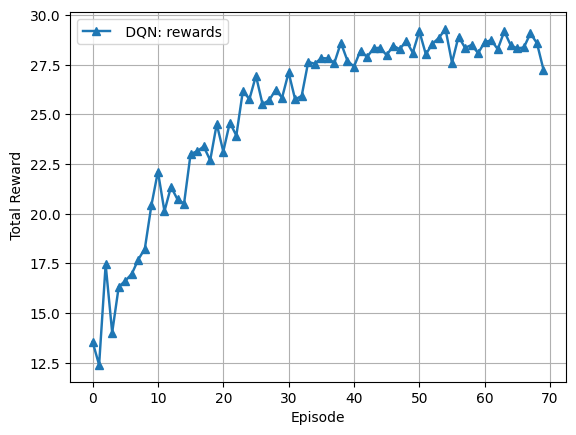

In [98]:
aver_dqn = []
log_total_reward_dqn = log_total_reward
step = (len(log_total_reward_dqn)+1)/num_episodes
for i in range(0, len(log_total_reward_dqn), int(step)):
  dqn_eps_i = log_total_reward_dqn[i:i+int(step)-1]
  aver_dqn.append(np.mean(dqn_eps_i))
  i += 1

plt.grid()
plt.plot(aver_dqn, "^-", label=' DQN: rewards', linewidth=1.75)
plt.xlabel("Episode")
plt.ylabel(" Total Reward")
plt.legend(loc = "best")
plt.show()

In [96]:

import os
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
save_path = now.strftime("%d_%m_%Y_%H_%M_%S")
model_path = "_DQN_total_rw150mW.csv"
path = save_path + model_path
print(path)
episode = num_episodes 
num = int(step)*episode
with open(f'{path}','w') as f: 
    write = csv.writer(f) 
    for i in range(num):
         write.writerow([log_total_reward[i], log_comp_reward[i], log_cost_reward[i], log_anten_reward[i], log_connect_reward[i]])


06_04_2023_17_12_17_DQN_total_rw150mW.csv


In [97]:
print(np.mean(log_comp_reward[50:-1]))
print(np.mean(log_cost_reward[50:-1]))
print(np.mean(log_anten_reward[50:-1]))
print(np.mean(log_connect_reward[50:-1]))

22.669822030593544
1.2174488528136878
2.931543509142073
1.1714537963507947
